# SDDP and newsvendor

## Problema de newsvendor con variable entera

Consideremos el siguiente problema tipo newsvendor:

* El día anterior se debe hacer una reserva $u$ a precio $p$ por unidad, dejando el stock en $x = x_0+u$.
* Se recibe una demanda $D$. Si $D>x$, se debe comprar $D-x$ a precio $q$ y pagar una penalidad $K$.

El problema de costo medio queda:

$$\min_x \left\{ px + E\left[q(D-x)^+ + K \mathbf{1}_{\{D>x\}} \right]\right\}.$$

La función de costo futuro es:

$$V(x) = E\left[q(D-x)^+ + K \mathbf{1}_{\{D>x\}} \right].$$

El problema se descompone en dos etapas:

> **1a etapa (day ahead):**:
>
> $$\min_x \{px+V(x)\}.$$
>
> $x^*$ el valor que realiza el óptimo es el control óptimo y el stock de entrada a la segunda etapa.

> **2a etapa (same day):**:
>
> $$\min_y \{qy + K\mathbf{1}_{\{y>0\}}\},$$
>
> sujeto a:
>
> $$x^* + y \geqslant D.$$

Una formulación alternativa de la segunda etapa con variables enteras, tomando $z=\mathbf{1}_{\{y>0\}}$ es:

> **2a etapa (same day):**:
>
> $$\min_{y,z} \{qy + Kz\},$$
>
> sujeto a:
>
> $$x^* + y \geqslant D,$$
> $$0\leqslant y \leqslant \theta z,$$
> $$z\in\{0,1\}.$$
>
> siendo $\theta$ una cota superior de la máxima demanda.

Supongamos ahora que $D\sim U[0,\theta]$, en este caso la función de valor se puede calcular explícitamente (notar que siempre tengo que satisfacer la demanda por lo que la penalidad si $D>x$ la tengo que pagar sí o sí y el control del segundo paso es tomar $y=(D-x)$ si $D>x$.

Entonces:

$$\begin{align}
V(x) &= E\left[q(D-x)^+ + K\mathbf{1}_{\{D>x\}}\right]\\
&= q\frac{(\theta-x)^2}{2\theta} + K\frac{\theta-x}{\theta}.
\end{align}$$

La reserva previa óptima sale de plantear:

$$x^* : p + V'(x) =0$$

De donde $p - q\frac{\theta-x}{\theta} - \frac{K}{\theta} = 0$, o bien:

$$x^* = \theta \left[1-\frac{p-K/\theta}{q}\right].$$

Lo anterior vale siempre que $K<\theta$. En otro caso, conviene tomar $x^*=\theta$.

### Ejemplo

Tomemos $p=1, q=2, K=25, \theta=100$. Ploteamos $V(x)$ y calculamos el control óptimo

Compra óptima day ahead: 62.5


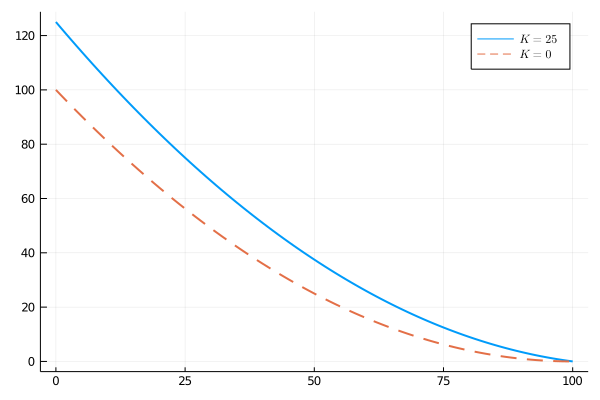

In [1]:
using Distributions, JuMP, GLPK, Plots, ProgressMeter, LaTeXStrings

p = 1.0 #day ahead price
q = 2.0 #same day price
K = 25.0
theta=100.0

V(x,p,q,K,theta) = q*(theta-x)^2/(2*theta) + K*(theta-x)/theta

xx=(0:100)

xast = theta*(1-(p-K/theta)/q)
println("Compra óptima day ahead: $xast")

plot(xx,V.(xx,p,q,K,theta),lw=2,label=L"K=25")
plot!(xx,V.(xx,p,q,0.0,theta),ls=:dash,lw=2,label=L"K=0")


### Solución mediante SDDP relajado.

Hacemos una pasada forward con el problema de day ahead y una backward con el problema relajado del same day.

> **2a etapa (same day relaxed):**:
>
> $$\min_y \{qy + Kz\},$$
>
> sujeto a:
>
> $$x^* + y \geqslant D,$$
> $$0\leqslant y \leqslant \theta z,$$
> $$0\leqslant z \leqslant 1.$$
>
> siendo $\theta$ una cota superior de la máxima demanda.

In [15]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];
explored_states=[100.0];
estimated_costs=[0.0];


@showprogress for i=1:100
    #resuelvo el primer paso
    
    model = JuMP.Model(GLPK.Optimizer)
    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF) ##apago los logs
    
    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
    end

    fix_x = @constraint(model,stock==0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x=value(stock)+value(reserve);
    push!(explored_states,x)
    #demand=rand(DiscreteUniform(0,100));
    #resuelvo para todos los ruidos el segundo paso y agrego un corte
    local_cuts = [];
    local_costs = [];

    for demand=(0:theta)
        

        model = JuMP.Model(GLPK.Optimizer)
        set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF) ##apago los logs
    
        @variable(model,shortage>=0);
        @variable(model,stock>=0);
        @variable(model,0<=penalty_indicator<=1)
        
        @constraint(model,stock-demand+shortage>=0);

        @constraint(model, shortage<=theta*penalty_indicator)
        
        fix_x = @constraint(model,stock==x);

        @objective(model,Min,q*shortage+K*penalty_indicator);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x)

        push!(local_cuts,[beta-lambda*x;lambda])
        push!(local_costs,beta)
    end

    new_cut = 1/length(local_cuts)*[sum([c[1] for c in local_cuts]);sum([c[2] for c in local_cuts])];
    push!(cuts,new_cut);
    push!(estimated_costs,sum(local_costs)/length(local_costs))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


### Animación de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp.gif
└ @ Plots /home/andres/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp.gif")
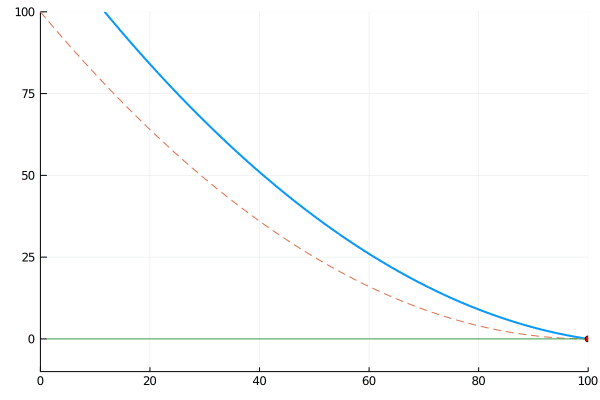

In [16]:
#Ploteo los cuts obtenidos
x=(0:100)
pl=plot(;legend=:none,xlim=(0,100),ylim=(-10,100))
plot!(pl,x,V.(x, p, q, K, theta),lw=2)
plot!(pl,x,V.(x, p, q, 0.0, theta),lw=1, ls=:dash)

anim=nothing
anim = @animate for i=1:length(cuts)
    cut=cuts[i]
    plot!(pl,cut[1].+cut[2]*x);
    scatter!(pl,[explored_states[i]],[estimated_costs[i]], markersize=4, markercolor=:red)
end

gif(anim,"tmp.gif",fps=4)

### Resuelvo el problema de stock

In [20]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(GLPK.Optimizer)
set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF) ##apago los logs
    

@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);
costo_real = p*x+V.(x,p,q,K,theta)
costo_optimo = p*62.5+V.(62.5,p,q,K,theta)

println("Control elegido: $x")
println("Control estimado: $costo")
println("Costo real: $costo_real")
println("Costo optimo: $costo_optimo")

Control elegido: 55.99999999999976
Control estimado: 78.05445544554456
Costo real: 86.36000000000004
Costo optimo: 85.9375
